In [1]:
#libraries we need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date
pd.options.mode.chained_assignment = None
import h2o
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

#libraries we need
# !pip install h2o

from scipy.special import expit
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from h2o.estimators import H2OGradientBoostingEstimator
SEED  = 1111   # global random seed for better reproducibility

from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

# conda install -c conda-forge pydotplus

h2o.init(max_mem_size='24G', nthreads=4) # start h2o with plenty of memory and threads
h2o.remove_all()                         # clears h2o memory
h2o.no_progress() 

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,4 hours 8 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.5
H2O_cluster_version_age:,"21 days, 3 hours and 49 minutes"
H2O_cluster_name:,H2O_from_python_vibhz_cyy3o1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.12 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [2]:
train = pd.read_csv('adult.data.txt',
                    names=['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','class'])

In [3]:
test = pd.read_csv('adult.test.txt',
                    names=['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','class'])

In [4]:
train.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [5]:
train.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
class             object
dtype: object

In [6]:
train.shape

(32561, 15)

In [7]:
test

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
5,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
6,29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K
7,63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
8,24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
9,55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K


In [8]:
## USE THE ABOVE TO REMOVE THE '?'

Replace all entries that contains ? with Null

In [9]:
train=train.replace(' ?', np.nan)

test=test.replace(' ?', np.nan)

Fill Null with 'None' type

In [10]:
train.update(train[['native-country','occupation','workclass']].fillna('None'))
test.update(test[['native-country','occupation','workclass']].fillna('None'))

In [11]:
train.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
class             0
dtype: int64

In [12]:
test.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
class             0
dtype: int64

train.head()

test.head()

In [13]:
train.to_csv('train.csv',index=False)

In [14]:
test.to_csv('test.csv',index=False)

## GLM

GLM can produce two categories of models: classification and regression.

Logistic regression is the GLM performing binary classification.

In [15]:
hf=h2o.H2OFrame(train)
gf=h2o.H2OFrame(test)

In [16]:
response_col = 'class'
predictors = list(train.columns.values)
predictors.remove('class')

In [17]:
glm_model = H2OGeneralizedLinearEstimator(family= "binomial",
                                          lambda_ = 0,
                                          compute_p_values = True,remove_collinear_columns=True)
glm_model.train(predictors, response_col, training_frame= hf,validation_frame=gf)

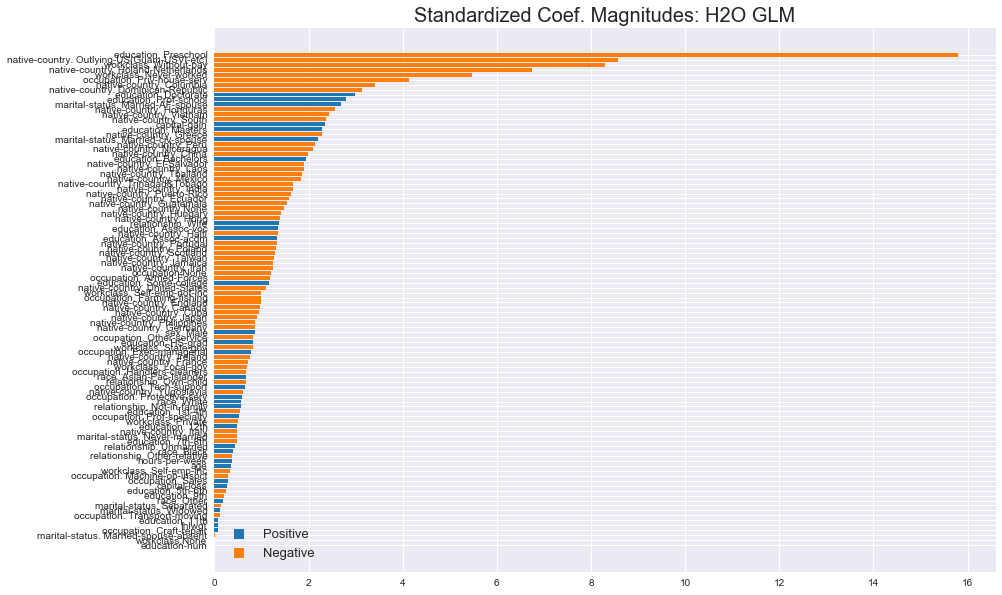

In [18]:
glm_model.std_coef_plot()

In [19]:
glm_model

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_model_python_1594326973870_1603


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,None,100,98,8,Key_Frame__upload_95839c0d88bfaa67354b21c965f9465d.hex




ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.10106348033611579
RMSE: 0.31790482905441336
LogLoss: 0.315792344968135
Null degrees of freedom: 32560
Residual degrees of freedom: 32462
Null deviance: 35948.079435207605
Residual deviance: 20565.02908901489
AIC: 20763.02908901489
AUC: 0.9088752373735435
AUCPR: 0.7712473241115264
Gini: 0.817750474747087

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37674918983051864: 


,,<=50K,>50K,Error,Rate
0,<=50K,21914.0,2806.0,0.1135,(2806.0/24720.0)
1,>50K,2179.0,5662.0,0.2779,(2179.0/7841.0)
2,Total,24093.0,8468.0,0.1531,(4985.0/32561.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.376749,0.694341,201.0
1,max f2,0.146548,0.792030,296.0
2,max f0point5,0.547036,0.712320,144.0
3,max accuracy,0.488259,0.853966,163.0
4,max precision,0.997192,0.995204,2.0
5,max recall,0.001349,1.000000,397.0
6,max specificity,0.999824,0.999919,0.0
7,max absolute_mcc,0.376749,0.593197,201.0
8,max min_per_class_accuracy,0.272046,0.821196,243.0
9,max mean_per_class_accuracy,0.212801,0.826971,267.0



Gains/Lift Table: Avg response rate: 24.08 %, avg score: 28.52 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010012,1.049468,0.229288,0.229288,0.055215,11.132056,0.055215,11.132056,0.002296,0.002296,-77.071207,-77.071207
1,,2,0.020024,0.815509,2.012638,1.120963,0.484663,0.940024,0.269939,6.036040,0.020150,0.022446,101.263846,12.096319
2,,3,0.030005,0.604610,0.613316,0.952094,0.147692,0.701607,0.229273,4.261535,0.006122,0.028568,-38.668419,-4.790620
3,,4,0.040017,0.486692,0.649649,0.876425,0.156442,0.528956,0.211051,3.327674,0.006504,0.035072,-35.035088,-12.357540
4,,5,0.050029,0.430940,0.777031,0.856534,0.187117,0.457096,0.206262,2.753206,0.007780,0.042852,-22.296870,-14.346626
5,,6,0.100028,0.295723,0.691260,0.773922,0.166462,0.345382,0.186368,1.549664,0.034562,0.077414,-30.874041,-22.607796
6,,7,0.150026,0.253039,0.479545,0.675817,0.115479,0.273653,0.162743,1.124414,0.023977,0.101390,-52.045460,-32.418342
7,,8,0.200025,0.225380,0.446385,0.618468,0.107494,0.239032,0.148933,0.903102,0.022319,0.123709,-55.361465,-38.153242
8,,9,0.300021,0.187603,0.442559,0.559837,0.106572,0.201473,0.134814,0.669250,0.044255,0.167963,-55.744081,-44.016255
9,,10,0.400018,0.167851,0.580301,0.564953,0.139742,0.177463,0.136046,0.546313,0.058028,0.225992,-41.969905,-43.504707




ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.10186864724194451
RMSE: 0.319168681486678
LogLoss: 0.32007159216651965
Null degrees of freedom: 16280
Residual degrees of freedom: 16182
Null deviance: 17803.226528187093
Residual deviance: 10422.17118412626
AIC: 10620.17118412626
AUC: 0.9043290738465083
AUCPR: 0.7620463495075838
Gini: 0.8086581476930166

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35971235775242977: 


,,<=50K,>50K,Error,Rate
0,<=50K,10912.0,1523.0,0.1225,(1523.0/12435.0)
1,>50K,1047.0,2799.0,0.2722,(1047.0/3846.0)
2,Total,11959.0,4322.0,0.1579,(2570.0/16281.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.359712,0.685357,205.0
1,max f2,0.152187,0.783103,294.0
2,max f0point5,0.567155,0.704723,133.0
3,max accuracy,0.498998,0.852712,156.0
4,max precision,0.987869,0.996622,6.0
5,max recall,0.000340,1.000000,399.0
6,max specificity,0.999890,0.999920,0.0
7,max absolute_mcc,0.401633,0.584095,189.0
8,max min_per_class_accuracy,0.265866,0.818094,244.0
9,max mean_per_class_accuracy,0.212904,0.820168,268.0



Gains/Lift Table: Avg response rate: 23.62 %, avg score: 30.20 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010012,1.102738,0.337620,0.337620,0.079755,12.667286,0.079755,12.667286,0.003380,0.003380,-66.238048,-66.238048
1,,2,0.020023,0.829587,2.311395,1.324507,0.546012,0.987881,0.312883,6.827583,0.023141,0.026521,131.139516,32.450734
2,,3,0.030035,0.634733,0.779122,1.142712,0.184049,0.730132,0.269939,4.795099,0.007800,0.034321,-22.087804,14.271221
3,,4,0.040047,0.494560,0.701210,1.032337,0.165644,0.550240,0.243865,3.733885,0.007020,0.041342,-29.879023,3.233660
4,,5,0.050058,0.426691,0.571356,0.940141,0.134969,0.460105,0.222086,3.079129,0.005720,0.047062,-42.864389,-5.985950
5,,6,0.100055,0.295184,0.743675,0.841968,0.175676,0.343065,0.198895,1.711937,0.037181,0.084243,-25.632458,-15.803174
6,,7,0.150052,0.255160,0.431644,0.705249,0.101966,0.274377,0.166598,1.232946,0.021581,0.105824,-56.835622,-29.475058
7,,8,0.200049,0.226568,0.431644,0.636869,0.101966,0.239846,0.150445,0.984747,0.021581,0.127405,-56.835622,-36.313099
8,,9,0.300043,0.187957,0.470648,0.581473,0.111179,0.202312,0.137359,0.723989,0.047062,0.174467,-52.935227,-41.852674
9,,10,0.400037,0.168472,0.494050,0.559621,0.116708,0.178062,0.132197,0.587528,0.049402,0.223869,-50.594989,-44.037917




Scoring History: 


,,timestamp,duration,iterations,negative_log_likelihood,objective
0,,2020-07-09 20:44:16,0.000 sec,0,17974.039718,0.552011
1,,2020-07-09 20:44:16,0.014 sec,1,11870.983007,0.364577
2,,2020-07-09 20:44:16,0.019 sec,2,10697.764911,0.328545
3,,2020-07-09 20:44:16,0.024 sec,3,10341.277080,0.317597
4,,2020-07-09 20:44:16,0.031 sec,4,10287.701867,0.315952
5,,2020-07-09 20:44:16,0.037 sec,5,10282.677384,0.315797
6,,2020-07-09 20:44:16,0.043 sec,6,10282.540629,0.315793
7,,2020-07-09 20:44:16,0.048 sec,7,10282.521293,0.315793
8,,2020-07-09 20:44:16,0.054 sec,8,10282.514545,0.315792


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35971235775242977: 


Gains/Lift Table: Avg response rate: 23.62 %, avg score: 30.20 %


AUC: 0.9043290738465083

In [20]:
glm_pred = glm_model.predict(gf)
glm_pred

predict,<=50K,>50K,StdErr
<=50K,0.99773,0.00226997,0.231683
<=50K,0.881624,0.118376,0.127049
>50K,0.616993,0.383007,0.142552
>50K,0.22624,0.77376,0.133312
<=50K,0.998745,0.00125482,0.192673
<=50K,0.995469,0.00453062,0.192952
<=50K,0.989807,0.0101928,0.172051
>50K,0.109742,0.890258,0.140758
<=50K,0.993699,0.00630083,0.160293
<=50K,0.951492,0.0485077,0.190746


In [21]:
predictions = glm_pred.as_data_frame()
# Create the pandas DataFrame 


In [22]:
predictions = predictions.drop(['predict',' <=50K','StdErr'],axis=1)

In [23]:
predictions['glm']=predictions[' >50K']
predictions=predictions.drop([' >50K'],axis =1)

## GLM WITH HYPERPARAMETERS

In [24]:
# Example of values to grid over for `lambda`
# import Grid Search

hyper_params = {'lambda': [1, 0.5, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0]}


glm = H2OGeneralizedLinearEstimator(family = 'binomial',remove_collinear_columns=True)

grid = H2OGridSearch(model = glm, hyper_params = hyper_params,
                     search_criteria = {'strategy': "Cartesian"})

grid.train(x = predictors, y = response_col, training_frame = hf, validation_frame = gf,nfolds=5,seed=1)

In [25]:
grid_table = grid.get_grid(sort_by = 'auc', decreasing = True)
grid_table

       lambda  \
0    [1.0E-5]   
1    [1.0E-4]   
2       [0.0]   
3     [0.001]   
4      [0.01]   
5       [0.1]   
6       [1.0]   
7       [0.5]   

                                                               model_ids  \
0  Grid_GLM_Key_Frame__upload_95839c0d88bfaa67354b21c965f9465d.hex_mo...   
1  Grid_GLM_Key_Frame__upload_95839c0d88bfaa67354b21c965f9465d.hex_mo...   
2  Grid_GLM_Key_Frame__upload_95839c0d88bfaa67354b21c965f9465d.hex_mo...   
3  Grid_GLM_Key_Frame__upload_95839c0d88bfaa67354b21c965f9465d.hex_mo...   
4  Grid_GLM_Key_Frame__upload_95839c0d88bfaa67354b21c965f9465d.hex_mo...   
5  Grid_GLM_Key_Frame__upload_95839c0d88bfaa67354b21c965f9465d.hex_mo...   
6  Grid_GLM_Key_Frame__upload_95839c0d88bfaa67354b21c965f9465d.hex_mo...   
7  Grid_GLM_Key_Frame__upload_95839c0d88bfaa67354b21c965f9465d.hex_mo...   

                   auc  
0   0.9066950328309124  
1   0.9064514115290591  
2   0.9064187900790345  
3   0.9035287787948915  
4   0.8979748053856812  
5   0.81899

In [26]:
best = grid_table.models[0]
print(best.actual_params['lambda'])

[1e-05]


In [27]:
best

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  Grid_GLM_Key_Frame__upload_95839c0d88bfaa67354b21c965f9465d.hex_model_python_1594326973870_1606_model_7


GLM Model: summary


,,family,link,regularization,number_of_predictors_total,number_of_active_predictors,number_of_iterations,training_frame
0,,binomial,logit,"Elastic Net (alpha = 0.5, lambda = 1.0E-5 )",108,96,4,Key_Frame__upload_95839c0d88bfaa67354b21c965f9465d.hex




ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.10109197433481228
RMSE: 0.3179496411930862
LogLoss: 0.31595218647655404
Null degrees of freedom: 32560
Residual degrees of freedom: 32464
Null deviance: 35948.079435207605
Residual deviance: 20575.43828772615
AIC: 20769.43828772615
AUC: 0.9088579747811375
AUCPR: 0.770910989807437
Gini: 0.817715949562275

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2945082987400751: 


,,<=50K,>50K,Error,Rate
0,<=50K,20737.0,3983.0,0.1611,(3983.0/24720.0)
1,>50K,1554.0,6287.0,0.1982,(1554.0/7841.0)
2,Total,22291.0,10270.0,0.1701,(5537.0/32561.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.294508,0.694274,234.0
1,max f2,0.152236,0.791826,292.0
2,max f0point5,0.547906,0.711984,140.0
3,max accuracy,0.487982,0.853905,161.0
4,max precision,0.994652,0.995842,3.0
5,max recall,0.000955,1.000000,398.0
6,max specificity,0.999805,0.999919,0.0
7,max absolute_mcc,0.377371,0.592814,202.0
8,max min_per_class_accuracy,0.271666,0.821157,243.0
9,max mean_per_class_accuracy,0.222228,0.827252,263.0



Gains/Lift Table: Avg response rate: 24.08 %, avg score: 24.12 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010012,9.974428e-01,4.127183,4.127183,0.993865,0.999329,0.993865,0.999329,0.041321,0.041321,312.718266,312.718266
1,,2,0.020024,9.772899e-01,4.076230,4.101706,0.981595,0.991030,0.987730,0.995179,0.040811,0.082132,307.622979,310.170623
2,,3,0.030005,9.427721e-01,3.948220,4.050649,0.950769,0.960295,0.975435,0.983575,0.039408,0.121541,294.822050,305.064905
3,,4,0.040017,9.055998e-01,3.719560,3.967813,0.895706,0.923977,0.955487,0.968664,0.037240,0.158781,271.955968,296.781318
4,,5,0.050029,8.696060e-01,3.592178,3.892640,0.865031,0.887153,0.937385,0.952352,0.035965,0.194746,259.217750,289.263993
5,,6,0.100028,7.271906e-01,3.285396,3.589111,0.791155,0.795357,0.864292,0.873879,0.164265,0.359010,228.539614,258.911126
6,,7,0.150026,6.064085e-01,2.729328,3.302575,0.657248,0.665012,0.795292,0.804271,0.136462,0.495473,172.932754,230.257535
7,,8,0.200025,4.941728e-01,2.318653,3.056633,0.558354,0.549083,0.736066,0.740484,0.115929,0.611402,131.865302,205.663254
8,,9,0.300021,3.135677e-01,1.669481,2.594296,0.402027,0.396907,0.624731,0.625970,0.166943,0.778345,66.948119,159.429609
9,,10,0.400018,1.933099e-01,1.142746,2.231437,0.275184,0.251542,0.537351,0.532370,0.114271,0.892616,14.274648,123.143655




ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.1018047064504984
RMSE: 0.3190684980540987
LogLoss: 0.318451243908791
Null degrees of freedom: 16280
Residual degrees of freedom: 16184
Null deviance: 17803.226528187093
Residual deviance: 10369.409404158052
AIC: 10563.409404158052
AUC: 0.904836444362479
AUCPR: 0.7620522036014005
Gini: 0.809672888724958

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3688547897175389: 


,,<=50K,>50K,Error,Rate
0,<=50K,10980.0,1455.0,0.117,(1455.0/12435.0)
1,>50K,1077.0,2769.0,0.28,(1077.0/3846.0)
2,Total,12057.0,4224.0,0.1555,(2532.0/16281.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.368855,0.686245,202.0
1,max f2,0.153460,0.782943,290.0
2,max f0point5,0.561082,0.705285,133.0
3,max accuracy,0.475972,0.852773,163.0
4,max precision,0.986438,0.996575,6.0
5,max recall,0.001486,1.000000,397.0
6,max specificity,0.999856,0.999920,0.0
7,max absolute_mcc,0.371934,0.584489,201.0
8,max min_per_class_accuracy,0.267299,0.817853,241.0
9,max mean_per_class_accuracy,0.214404,0.820088,265.0



Gains/Lift Table: Avg response rate: 23.62 %, avg score: 23.77 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010012,0.997265,4.207259,4.207259,0.993865,0.999348,0.993865,0.999348,0.042122,0.042122,320.725860,320.725860
1,,2,0.020023,0.975668,4.207259,4.207259,0.993865,0.990128,0.993865,0.994738,0.042122,0.084243,320.725860,320.725860
2,,3,0.030035,0.938905,3.999493,4.138003,0.944785,0.959050,0.977505,0.982842,0.040042,0.124285,299.949274,313.800331
3,,4,0.040047,0.896042,3.843668,4.064420,0.907975,0.917322,0.960123,0.966462,0.038482,0.162767,284.366835,306.441957
4,,5,0.050058,0.857753,3.635902,3.978716,0.858896,0.876710,0.939877,0.948511,0.036401,0.199168,263.590249,297.871615
5,,6,0.100055,0.713599,3.297134,3.638134,0.778870,0.783343,0.859423,0.865978,0.164847,0.364015,229.713439,263.813448
6,,7,0.150052,0.598097,2.683472,3.320044,0.633907,0.655249,0.784282,0.795764,0.134165,0.498180,168.347215,232.004396
7,,8,0.200049,0.485653,2.241427,3.050473,0.529484,0.540630,0.720602,0.732000,0.112064,0.610244,124.142732,205.047259
8,,9,0.300043,0.307310,1.658968,2.586733,0.391892,0.389652,0.611054,0.617907,0.165887,0.776131,65.896825,158.673276
9,,10,0.400037,0.189368,1.107712,2.217034,0.261671,0.246380,0.523722,0.525040,0.110764,0.886895,10.771234,121.703443




ModelMetricsBinomialGLM: glm
** Reported on cross-validation data. **

MSE: 0.10216354786983954
RMSE: 0.3196303300217918
LogLoss: 0.3193483690960733
Null degrees of freedom: 32560
Residual degrees of freedom: 32463
Null deviance: 35950.56206907465
Residual deviance: 20796.604492274488
AIC: 20992.604492274488
AUC: 0.9066950328309124
AUCPR: 0.7663264915247856
Gini: 0.8133900656618247

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30524369345207736: 


,,<=50K,>50K,Error,Rate
0,<=50K,20911.0,3809.0,0.1541,(3809.0/24720.0)
1,>50K,1686.0,6155.0,0.215,(1686.0/7841.0)
2,Total,22597.0,9964.0,0.1688,(5495.0/32561.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.305244,0.691379,233.0
1,max f2,0.154627,0.789111,297.0
2,max f0point5,0.558688,0.710457,140.0
3,max accuracy,0.503761,0.851878,160.0
4,max precision,0.996770,0.995062,2.0
5,max recall,0.000404,1.000000,399.0
6,max specificity,0.999814,0.999919,0.0
7,max absolute_mcc,0.411719,0.587422,192.0
8,max min_per_class_accuracy,0.270490,0.819862,248.0
9,max mean_per_class_accuracy,0.229928,0.824446,265.0



Gains/Lift Table: Avg response rate: 24.08 %, avg score: 24.11 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010012,9.974436e-01,4.127183,4.127183,0.993865,0.999342,0.993865,0.999342,0.041321,0.041321,312.718266,312.718266
1,,2,0.020024,9.776131e-01,4.063492,4.095337,0.978528,0.991038,0.986196,0.995190,0.040684,0.082005,306.349157,309.533712
2,,3,0.030005,9.433434e-01,3.909888,4.033647,0.941538,0.960977,0.971341,0.983809,0.039026,0.121030,290.988826,303.364738
3,,4,0.040017,9.067515e-01,3.745036,3.961439,0.901840,0.924630,0.953952,0.969003,0.037495,0.158526,274.503612,296.143919
4,,5,0.050029,8.693362e-01,3.592178,3.887542,0.865031,0.887846,0.936157,0.952761,0.035965,0.194490,259.217750,288.754151
5,,6,0.100028,7.271394e-01,3.252236,3.569986,0.783170,0.795787,0.859687,0.874298,0.162607,0.357097,225.223609,256.998633
6,,7,0.150026,6.062118e-01,2.731878,3.290674,0.657862,0.665610,0.792426,0.804750,0.136590,0.493687,173.187831,229.067418
7,,8,0.200025,4.950790e-01,2.257434,3.032404,0.543612,0.548779,0.730232,0.740767,0.112868,0.606555,125.743446,203.240391
8,,9,0.300021,3.133257e-01,1.694989,2.586645,0.408170,0.396885,0.622889,0.626151,0.169494,0.776049,69.498893,158.664455
9,,10,0.400018,1.928270e-01,1.138920,2.224741,0.274263,0.251068,0.535739,0.532388,0.113889,0.889938,13.892032,122.474128




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.8383464,0.013066367,0.8308824,0.81901366,0.84780633,0.8496299,0.8443999
1,auc,0.9067729,0.0059722103,0.9023399,0.8984996,0.9106697,0.91063833,0.911717
2,aucpr,0.766541,0.017469566,0.75910425,0.746244,0.766701,0.79398966,0.76666605
3,err,0.16165356,0.013066367,0.16911764,0.18098636,0.15219365,0.15037014,0.15560006
4,err_count,1052.4,80.21409,1104.0,1167.0,1006.0,975.0,1010.0
5,f0point5,0.66045815,0.026054692,0.64955807,0.6240409,0.6768509,0.69209874,0.65974206
6,f1,0.6937628,0.01172566,0.6884876,0.6764624,0.70166075,0.70623684,0.6959663
7,f2,0.73132044,0.006972574,0.73238087,0.7384988,0.72835857,0.72096455,0.73639953
8,lift_top_group,4.1291766,0.099577524,4.09279,4.093359,4.113293,4.0449157,4.301524
9,logloss,0.3193717,0.010493397,0.32771584,0.3327602,0.31491843,0.31408235,0.3073817



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,iterations,negative_log_likelihood,objective
0,,2020-07-09 20:44:22,0.000 sec,0,17974.039718,0.552011
1,,2020-07-09 20:44:22,0.010 sec,1,11871.013314,0.364890
2,,2020-07-09 20:44:22,0.014 sec,2,10697.780200,0.329136
3,,2020-07-09 20:44:22,0.021 sec,3,10341.290650,0.318606
4,,2020-07-09 20:44:22,0.026 sec,4,10287.719144,0.317573


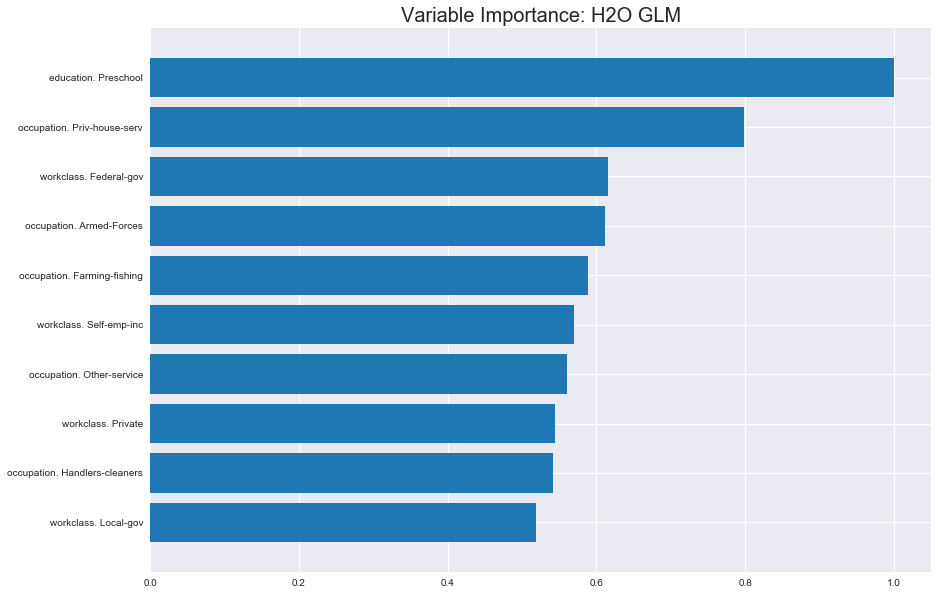

In [28]:
best.varimp_plot()

In [29]:
best.predict(gf)

predict,<=50K,>50K
<=50K,0.997053,0.00294736
<=50K,0.881809,0.118191
>50K,0.615354,0.384646
>50K,0.245103,0.754897
<=50K,0.99836,0.00164031
<=50K,0.995252,0.00474843
<=50K,0.989423,0.0105771
>50K,0.115269,0.884731
<=50K,0.993285,0.00671539
<=50K,0.950483,0.0495174


In [30]:
x = best.predict(gf)
x=x.as_data_frame()
x=x[' >50K']
predictions['glm_hyp']=x

AUC: 0.9066950328309124

## GBM

#### PRE-PROCESSING FOR GBM


In [31]:
ss = hf.split_frame(seed = 1)
train_hf = ss[0]
valid_hf = ss[1]

### GBM WITHOUT HYPRERPARAMETERS

In [32]:
gbm = H2OGradientBoostingEstimator(nfolds=5,
                                        seed=1111,
                                        keep_cross_validation_predictions = True)
gbm.train(x=predictors, y=response_col, training_frame=hf)

# Eval performance:
perf = gbm.model_performance(gf)

# Generate predictions on a test set:
gbm_pred = gbm.predict(gf)

In [33]:
gbm.model_performance(gf)


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.09033907842424388
RMSE: 0.30056459941956554
LogLoss: 0.2885572457637678
Mean Per-Class Error: 0.16016157654750096
AUC: 0.9234384268816671
AUCPR: 0.8176605598174321
Gini: 0.8468768537633342

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.29262006582812056: 


,,<=50K,>50K,Error,Rate
0,<=50K,10688.0,1747.0,0.1405,(1747.0/12435.0)
1,>50K,728.0,3118.0,0.1893,(728.0/3846.0)
2,Total,11416.0,4865.0,0.152,(2475.0/16281.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.292620,0.715876,228.0
1,max f2,0.184677,0.801689,272.0
2,max f0point5,0.570050,0.757417,131.0
3,max accuracy,0.503043,0.872428,153.0
4,max precision,0.983083,1.000000,0.0
5,max recall,0.010606,1.000000,397.0
6,max specificity,0.983083,1.000000,0.0
7,max absolute_mcc,0.405929,0.626779,187.0
8,max min_per_class_accuracy,0.258507,0.836349,241.0
9,max mean_per_class_accuracy,0.211048,0.839838,261.0



Gains/Lift Table: Avg response rate: 23.62 %, avg score: 23.70 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010012,0.970993,4.233229,4.233229,1.000000,0.974792,1.000000,0.974792,0.042382,0.042382,323.322933,323.322933
1,,2,0.020023,0.967365,4.233229,4.233229,1.000000,0.969179,1.000000,0.971985,0.042382,0.084763,323.322933,323.322933
2,,3,0.030035,0.960682,4.233229,4.233229,1.000000,0.964553,1.000000,0.969508,0.042382,0.127145,323.322933,323.322933
3,,4,0.040047,0.945393,4.207259,4.226737,0.993865,0.953634,0.998466,0.965539,0.042122,0.169267,320.725860,322.673665
4,,5,0.050058,0.920521,4.181288,4.217647,0.987730,0.934491,0.996319,0.959330,0.041862,0.211128,318.128787,321.764689
5,,6,0.100055,0.734801,3.635169,3.926587,0.858722,0.802755,0.927563,0.881090,0.181747,0.392876,263.516867,292.658657
6,,7,0.150052,0.598405,2.792683,3.548774,0.659705,0.668582,0.838314,0.810283,0.139626,0.532501,179.268323,254.877350
7,,8,0.200049,0.473739,2.350638,3.249332,0.555283,0.535181,0.767578,0.741529,0.117525,0.650026,135.063840,224.933169
8,,9,0.300043,0.289117,1.625165,2.708054,0.383907,0.373741,0.639713,0.618958,0.162507,0.812533,62.516482,170.805356
9,,10,0.400037,0.169406,0.977699,2.275531,0.230958,0.224741,0.537540,0.520419,0.097764,0.910296,-2.230084,127.553138


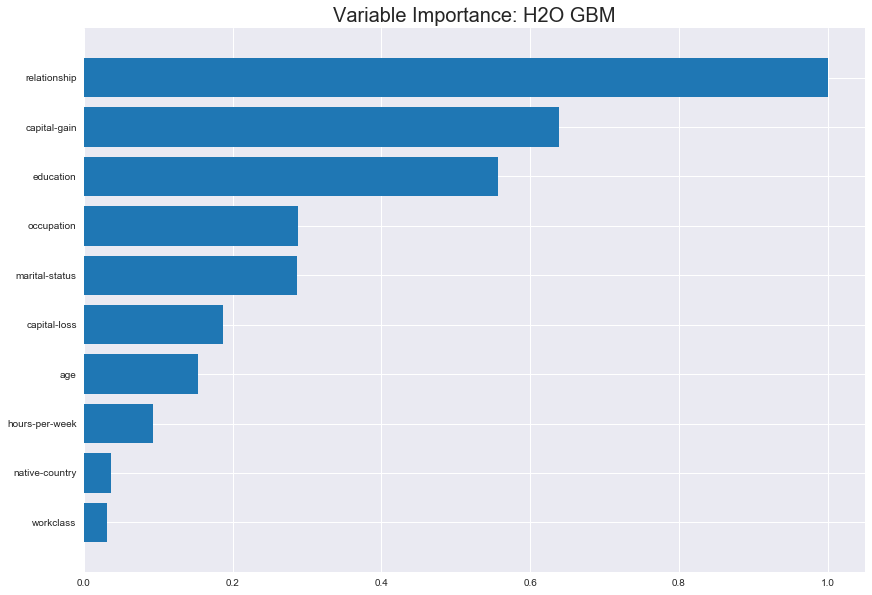

In [34]:
gbm.varimp_plot()

In [35]:
x = gbm.predict(gf)
x=x.as_data_frame()
x=x[' >50K']
predictions['gbm']=x

AUC: 0.9234384268816671

### GBM WITH HYPERPARAMETERS

* MAX DEPTH

In [36]:
#to load the model 
#best_gbm = h2o.import_mojo(path)

## XGBoost 

In [37]:
from h2o.estimators import H2OXGBoostEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,4 hours 8 mins
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.5
H2O_cluster_version_age:,"21 days, 3 hours and 49 minutes"
H2O_cluster_name:,H2O_from_python_vibhz_cyy3o1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,21.14 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


If skiped GLM and GBM

run the following:

hf=h2o.H2OFrame(train)
gf=h2o.H2OFrame(test)
response_col = 'class'
predictors = list(train.columns.values)
predictors.remove('class')
ss = hf.split_frame(seed = 1)
train_hf = ss[0]
valid_hf = ss[1]

In [38]:
# Build and train the model:
xgb = H2OXGBoostEstimator(booster='dart',
                                  normalize_type="tree",
                                  seed=1234)
xgb.train(x=predictors,
                  y=response_col,
                  training_frame=train_hf,
                  validation_frame=valid_hf)

In [39]:
# Eval performance:
xgb.model_performance(gf)


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.08752865128134162
RMSE: 0.29585241469581014
LogLoss: 0.2754554443836803
Mean Per-Class Error: 0.15473629801645628
AUC: 0.9280555090317806
AUCPR: 0.8264562170678743
Gini: 0.8561110180635612

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3006711637973785: 


,,<=50K,>50K,Error,Rate
0,<=50K,10726.0,1709.0,0.1374,(1709.0/12435.0)
1,>50K,686.0,3160.0,0.1784,(686.0/3846.0)
2,Total,11412.0,4869.0,0.1471,(2395.0/16281.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.300671,0.725186,227.0
1,max f2,0.159961,0.808360,285.0
2,max f0point5,0.664160,0.761383,105.0
3,max accuracy,0.526798,0.874455,150.0
4,max precision,0.998991,1.000000,0.0
5,max recall,0.000979,1.000000,397.0
6,max specificity,0.998991,1.000000,0.0
7,max absolute_mcc,0.447204,0.637639,175.0
8,max min_per_class_accuracy,0.267872,0.842622,240.0
9,max mean_per_class_accuracy,0.196426,0.845264,269.0



Gains/Lift Table: Avg response rate: 23.62 %, avg score: 23.52 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010012,0.998770,4.233229,4.233229,1.000000,0.999078,1.000000,0.999078,0.042382,0.042382,323.322933,323.322933
1,,2,0.020023,0.997824,4.233229,4.233229,1.000000,0.998333,1.000000,0.998705,0.042382,0.084763,323.322933,323.322933
2,,3,0.030035,0.994976,4.207259,4.224572,0.993865,0.996752,0.997955,0.998054,0.042122,0.126885,320.725860,322.457242
3,,4,0.040047,0.989234,4.233229,4.226737,1.000000,0.992251,0.998466,0.996603,0.042382,0.169267,323.322933,322.673665
4,,5,0.050058,0.978641,4.207259,4.222841,0.993865,0.984763,0.997546,0.994235,0.042122,0.211388,320.725860,322.284104
5,,6,0.100055,0.752499,3.671572,3.947376,0.867322,0.854541,0.932474,0.924431,0.183567,0.394956,267.157237,294.737591
6,,7,0.150052,0.626268,2.865491,3.586895,0.676904,0.688842,0.847319,0.845933,0.143266,0.538222,186.549061,258.689509
7,,8,0.200049,0.490065,2.350638,3.277926,0.555283,0.557434,0.774332,0.773831,0.117525,0.655746,135.063840,227.792581
8,,9,0.300043,0.298272,1.669369,2.741850,0.394349,0.385246,0.647697,0.644329,0.166927,0.822673,66.936931,174.185007
9,,10,0.400037,0.158436,0.975099,2.300230,0.230344,0.223597,0.543375,0.539162,0.097504,0.920177,-2.490111,130.023009


In [40]:
# Generate predictions on a test set (if necessary):
xgb_pred = xgb.predict(gf)

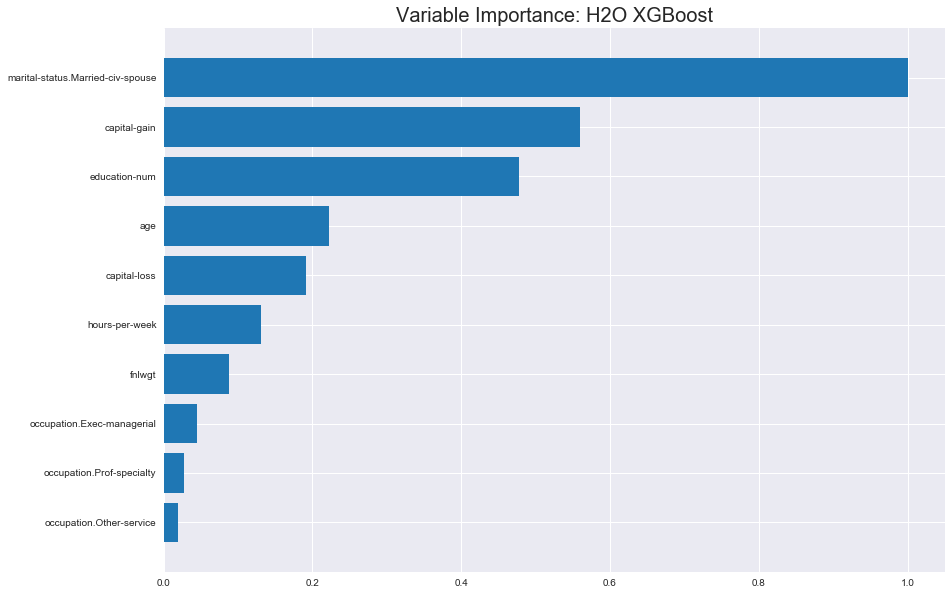

In [41]:
xgb.varimp_plot()

In [42]:
x = xgb.predict(gf)
x=x.as_data_frame()
x=x[' >50K']
predictions['xgb']=x

## Model Comparison

Plotting the residual values against the predicted values is a time-honored model assessment technique and a great way to see all your modeling results in two dimensions.

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

Give actual class lables: 

* <=50 -- 0    
* \>50 -- 1

In [44]:
class_dict = {0:'<=50K', 1:'>50K'}

In [45]:
test['label'] = pd.factorize(test['class'])[0]

In [46]:
predictions['actual']=test['label']

In [47]:
predictions=predictions.sort_values(by=['actual'])
predictions.head()

,glm,glm_hyp,gbm,xgb,actual
0,0.002270,0.002947,0.013364,0.001466,0
10112,0.070531,0.071753,0.129012,0.056514,0
10113,0.050879,0.051989,0.023922,0.013668,0
10115,0.161932,0.163608,0.030591,0.033277,0
10116,0.094219,0.095853,0.085771,0.081020,0


#### GLM Plot

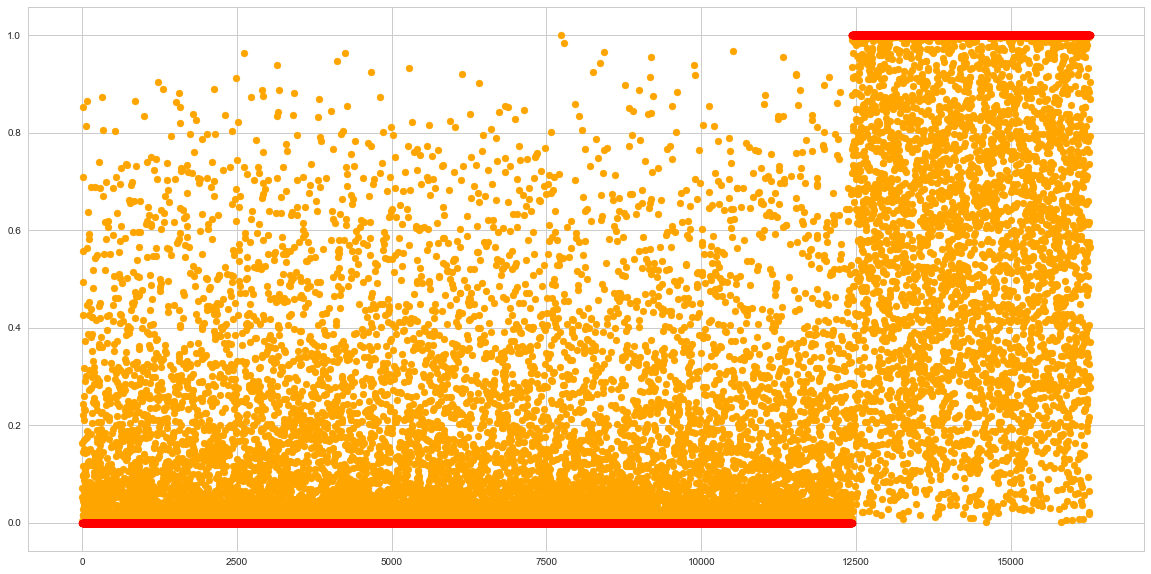

In [49]:
fig, ax = plt.subplots(figsize=(20, 10)) 
sns.set_style('whitegrid') 
test_sub = predictions.reset_index()
ax.scatter(values,predictions['glm_hyp'],color='orange')
ax.scatter(values,predictions['actual'],color='Red')
plt.show()

#### GBM Plot

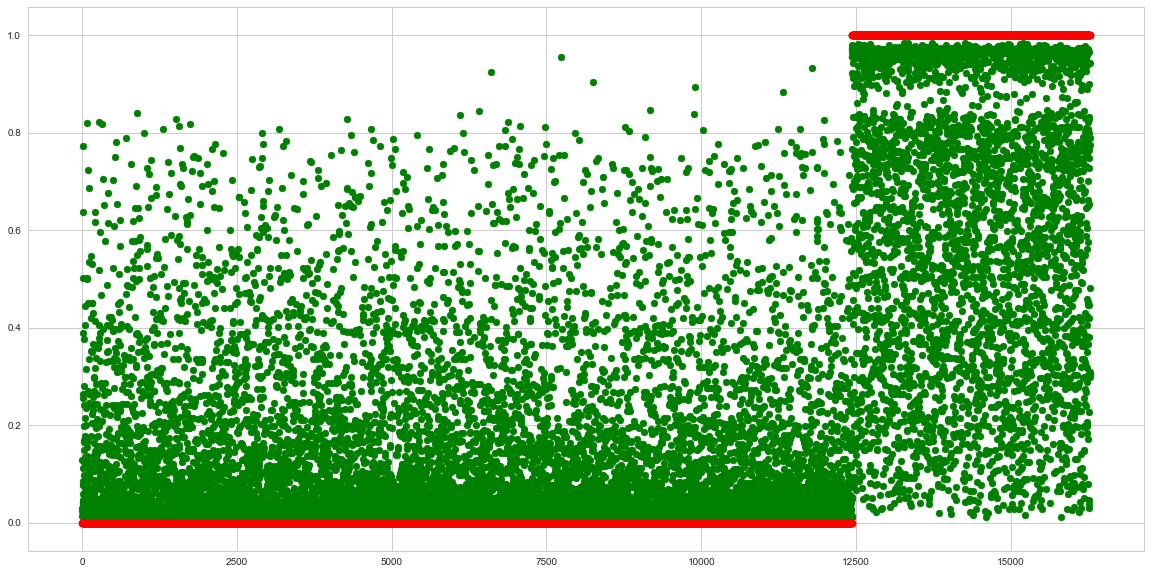

In [50]:
fig, ax = plt.subplots(figsize=(20, 10)) 
sns.set_style('whitegrid') 
test_sub = predictions.reset_index()
ax.scatter(values,predictions['gbm'],color='Green')
ax.scatter(values,predictions['actual'],color='Red')
plt.show()

#### XGB Plot

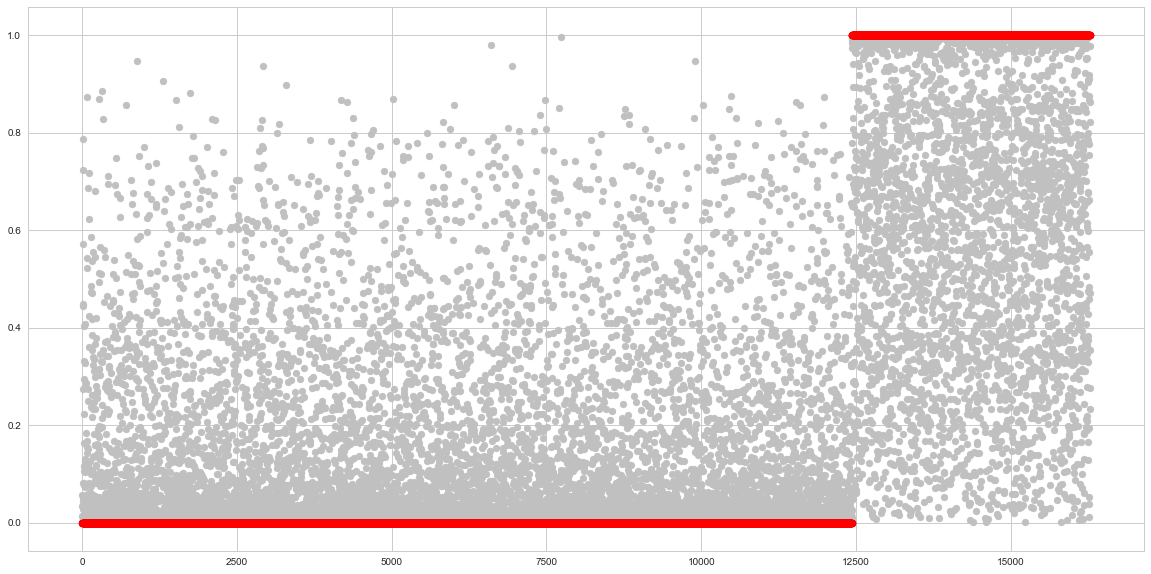

In [51]:
fig, ax = plt.subplots(figsize=(20, 10)) 
sns.set_style('whitegrid') 
test_sub = predictions.reset_index()
ax.scatter(values,predictions['xgb'],color='Silver')
ax.scatter(values,predictions['actual'],color='Red')
plt.show()

## Residual Analysis

Calculate logloss residuals for binomial classification
Logloss is one measure the GBM model used to make it's decisions. Logloss residuals can be calculated, analyzed, and explained in many ways to understand more about the model's errors.

-(y(log(y^)) + 1-y(log(1-y^)))

If skipped the previous plotting session, run these:

xgb_pred = xgb_pred.as_data_frame()
xgb_pred['xgb_yhat']=xgb_pred[" >50K"]

In [52]:
xgb_pred.head()

predict,<=50K,>50K
<=50K,0.998534,0.00146553
<=50K,0.748851,0.251149
>50K,0.594096,0.405904
>50K,0.00309676,0.996903
<=50K,0.999643,0.000357213
<=50K,0.991773,0.00822704
<=50K,0.994736,0.00526421
>50K,0.034991,0.965009
<=50K,0.993967,0.00603258
<=50K,0.968498,0.0315022


In [53]:
gf.shape

(16281, 15)

In [54]:
xgb_pred.shape

(16281, 3)

here we are using the test(gf) dataset to compare

In [55]:
validation = gf.as_data_frame()

In [56]:
validation["xgb_yhat"] = xgb_pred["xgb_yhat"]

H2OResponseError: Server error java.lang.IllegalArgumentException:
  Error: Column xgb_yhat not found
  Request: POST /99/Rapids
    data: {'ast': "(tmp= py_5_sid_96bc (cols_py transformation_b158_XGBoost_model_python_1594326973870_2245_on_Key_Frame__upload_a5c985b2a8fc7481a5db23ad17834bae.hex 'xgb_yhat'))", 'session_id': '_sid_96bc'}


In [ ]:
validation['real_y'] = pd.factorize(validation['class'])[0]

Calculating logloss

In [ ]:
validation['logloss'] = -validation['real_y']*np.log(validation["xgb_yhat"]) -\
                       (1 - validation['real_y'])*np.log(1 - validation["xgb_yhat"]) 

In [ ]:
validation

In [ ]:
 # initialize figure
fig, ax_ = plt.subplots(figsize=(8, 8))         

# plot groups with appropriate color
color_list = ['royalblue', 'magenta'] 
c_idx = 0
groups = validation.groupby("real_y") # define groups for levels of PAY_0
for name, group in groups:
    ax_.plot(group.xgb_yhat, group.logloss, 
             label=' '.join(["real_y", str(name)]),
             marker='o', linestyle='', color=color_list[c_idx], alpha=0.3)
    c_idx += 1

    # annotate plot
_ = plt.xlabel("xgb_yhat")
_ = plt.ylabel("logloss")
_ = ax_.legend(loc=1)
_ = plt.title('Global Logloss Residuals')

#### Sort data and display

* For class >50K  label = 1  Log loss risiduals

In [ ]:
validation_high = validation[validation["real_y"] == 1]
validation_high = validation_high.sort_values(by='logloss', ascending=False).reset_index(drop=True)
validation_high.head()

In [ ]:
validation_high.info

* For class <=50K  label = 0  Log loss risiduals

In [ ]:
validation_low = validation[validation["real_y"] == 0]
validation_low = validation_low.sort_values(by='logloss', ascending=False).reset_index(drop=True)
validation_low.head()

Group for Race using our xgb predicted yhat (probability)

In [ ]:
# use Seaborn FacetGrid for convenience
# some seaborn configs
sns.set(font_scale=0.9)                                         # legible font size
sns.set_style('whitegrid', {'axes.grid': False})                # white background, no grid in plots
sns.set_palette(sns.color_palette(["#4169e1", "#ff00ff"]))      # consistent colors

# facet grid of residuals by PAY_0 
sorted_ = validation.sort_values(by='race')                 # sort for better layout of by-groups
g = sns.FacetGrid(sorted_, col='race', hue="real_y", col_wrap=4) # init grid
_ = g.map(plt.scatter, "xgb_yhat", "logloss", alpha=0.4)        # plot points
_ = g.add_legend(bbox_to_anchor=(0.82, 0.2))                    # legend

Group for Occupation 

In [ ]:
# use Seaborn FacetGrid for convenience
# some seaborn configs
sns.set(font_scale=0.9)                                         # legible font size
sns.set_style('whitegrid', {'axes.grid': False})                # white background, no grid in plots
sns.set_palette(sns.color_palette(["#4169e1", "#ff00ff"]))      # consistent colors

sorted_ = validation.sort_values(by='occupation')                 # sort for better layout of by-groups
g = sns.FacetGrid(sorted_, col='occupation', hue="real_y", col_wrap=4) # init grid
_ = g.map(plt.scatter, "xgb_yhat", "logloss", alpha=0.4)        # plot points
_ = g.add_legend(bbox_to_anchor=(0.82, 0.2))                    # legend

## PD AND ICE

In [ ]:
def plot_par_dep_ICE(xs, par_dep_frame):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
    
    """
    
    # initialize figure and axis
    fig, ax = plt.subplots()
    
    # plot ICE curves
    par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                          colormap='gnuplot',
                                                          ax=ax)

    # overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence and ICE for ' + str(xs),
                       x=xs, 
                       y='partial_dependence',
                       style='r-', 
                       linewidth=3, 
                       ax=ax)

    # add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)

In [85]:
from rmltk import explain        # simple module for explaining

# init dict to hold partial dependence and ICE values
# for each feature
# for mgbm
mgbm_pd_ice_dict = {}

# calculate partial dependence for each selected feature
for xs in predictors: 
    mgbm_pd_ice_dict[xs] = explain.pd_ice(xs, test, xgb)

H2OResponseError: Server error java.lang.IllegalArgumentException:
  Error: Column p1 not found
  Request: POST /99/Rapids
    data: {'ast': "(tmp= py_11_sid_96bc (cols_py transformation_99ea_XGBoost_model_python_1594326973870_2245_on_Key_Frame__upload_9550f0b8283989ae56f21bbfdf1f42ca.hex 'p1'))", 'session_id': '_sid_96bc'}


https://resources.oreilly.com/oriole/interpretable-machine-learning-with-python-xgboost-and-h2o/blob/master/xgboost_pdp_ice.ipynb

http://savvastjortjoglou.com/intrepretable-machine-learning-nfl-combine.html#PDP-and-ICE-plots